In [1]:
!pip install pyspark

In [2]:
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 1.9 MB/s eta 0:00:00a 0:00:01


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
from pyspark.sql.functions import col, mean, corr, round
from pyspark.sql.types import FloatType, IntegerType

In [4]:
# Создание SparkSession
spark = SparkSession.builder \
    .appName("Economic Data Analysis") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://localhost:9000") \
    .config("spark.ui.port", "4050") \
    .getOrCreate()

# Установка количества разделов для shuffle операций
spark.conf.set("spark.sql.shuffle.partitions", "50")

25/05/31 23:07:21 WARN Utils: Your hostname, devopsvm resolves to a loopback address: 127.0.1.1; using 192.168.100.29 instead (on interface enp0s3)
25/05/31 23:07:21 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/31 23:07:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
# Чтение данных из HDFS
file_path = "hdfs://localhost:9000/user3/hadoop/input/economic_data/Countries of the world-2023.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True, sep=";", encoding ="utf-8")

# Просмотр первых строк данных
df.show(5)

25/05/31 23:09:55 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-----------+-------+------------+---------------------+--------------+-----------------+----------+------------+------------------+-------------+------+--------------+-------------+--------------+-----------------+--------------+-----------------+--------------------------------------+---------------------------------------+----------------+----------------+---------------+------------------------+------------+-----------------+--------------------------------+-----------------------+----------+-----------------------------------------+---------------+--------------+-----------------+----------------+----------+---------+
|    Country|Density|Abbreviation|Agricultural Land( %)|Land Area(Km2)|Armed Forces size|Birth Rate|Calling Code|Capital/Major City|Co2-Emissions|   CPI|CPI Change (%)|Currency-Code|Fertility Rate|Forested Area (%)|Gasoline Price|              GDP|Gross primary education enrollment (%)|Gross tertiary education enrollment (%)|Infant mortality|    Largest city|Life exp

## Очистка данных

In [7]:
# Функции для очистки данных
def clean_numeric(value):
    if value is None: 
        return None
    return float(value.replace('$', '').replace(',', '').replace('%', '').strip() or 0)

clean_udf = udf(clean_numeric, DoubleType())

# Загрузка данных
df = spark.read.csv(
    "hdfs://localhost:9000/user3/hadoop/input/economic_data/Countries of the world-2023.csv",
    header=True,
    sep=";"
)

# Очистка данных
df = df.withColumn("GDP_clean", clean_udf(col("GDP"))) \
       .withColumn("Population_clean", clean_udf(col("Population"))) \
       .withColumn("Density_clean", clean_udf(col("Density"))) \
       .withColumn("Urban_Population_clean", clean_udf(col("Urban_Population")))\
       .withColumn("Agricultural_Land_clean", clean_udf(col("Agricultural Land( %)"))) \
       .withColumn("Land_Area_clean", clean_udf(col("Land Area(Km2)"))) \
       .withColumn("CPI_Change_clean", clean_udf(col("CPI Change (%)")))\
       .withColumn("Forested_Area_clean", clean_udf(col("Forested Area (%)"))) \
       .withColumn("Gasoline_Price_clean", clean_udf(col("Gasoline Price"))) \
       .withColumn("Gross_primary_education_enrollment_clean", clean_udf(col("Gross primary education enrollment (%)")))\
       .withColumn("Gross_tertiary_education_enrollment_clean", clean_udf(col("Gross tertiary education enrollment (%)"))) \
       .withColumn("Minimum_wage_clean", clean_udf(col("Minimum wage"))) \
       .withColumn("Unemployment_rate_clean", clean_udf(col("Unemployment rate")))

In [8]:
# Список столбцов, которые нужно удалить
columns_to_drop = ["GDP", "Population", "Density", "Urban_Population", "Agricultural Land( %)", "Land Area(Km2)", "CPI Change (%)", "Forested Area (%)", "Gasoline Price", "Gross primary education enrollment (%)", "Gross tertiary education enrollment (%)", "Minimum wage", "Unemployment rate"]

# Удаление указанных столбцов
df_clean = df.drop(*columns_to_drop)

In [9]:
# Перевод названий столбцов на русский язык
column_mapping = {
    "Country": "Страна",
    "Density_clean": "Плотность",
    "Abbreviation": "Аббревиатура",
    "Agricultural_Land_clean": "Аграрные земли (%)",
    "Land_Area_clean": "Площадь (км2)",
    "Armed Forces size": "Размер вооруженных сил",
    "Birth Rate": "Рождаемость",
    "Calling Code": "Код страны",
    "Capital/Major City": "Столица",
    "Co2-Emissions": "Выбросы CO2",
    "CPI": "Индекс потребительских цен",
    "CPI_Change_clean": "Изменение CPI (%)",
    "Currency-Code": "Код валюты",
    "Fertility Rate": "Коэффициент рождаемости",
    "Forested_Area_clean": "Лесистая зона (%)",
    "Gasoline_Price_clean": "Цена бензина",
    "GDP_clean": "ВВП",
    "Gross_primary_education_enrollment_clean": "Обучение в начальной школе (%)",
    "Gross_tertiary_education_enrollment_clean": "Обучение в высшей школе (%)",
    "Infant mortality": "Детская смертность",
    "Largest city": "Крупнейший город",
    "Life expectancy": "Ожидаемая продолжительность жизни",
    "Maternal mortality ratio": "Материнская смертность",
    "Minimum_wage_clean": "Минимальная зарплата",
    "Official language": "Официальный язык",
    "Out of pocket health expenditure": "Личные траты на здоровье",
    "Physicians per thousand": "Врачи на тысячу",
    "Population_clean": "Население",
    "Population: Labor force participation (%)": "Доля рабочей силы (%)",
    "Tax revenue (%)": "Налоговые поступления (%)",
    "Total tax rate": "Общий налоговый уровень",
    "Unemployment_rate_clean": "Уровень безработицы",
    "Urban_Population_clean": "Городское население",
    "Latitude": "Широта",
    "Longitude": "Долгота"
}

# Переименование столбцов
for eng_name, rus_name in column_mapping.items():
    df_clean = df_clean.withColumnRenamed(eng_name, rus_name)

# Обработка типов данных: преобразование строковых чисел в числовые типы
numeric_columns = [
    "Плотность", "Аграрные земли (%)", "Площадь (км2)", "Размер вооруженных сил",
    "Рождаемость", "Код страны", "Выбросы CO2", "Индекс потребительских цен",
    "Изменение CPI (%)", "Коэффициент рождаемости", "Лесистая зона (%)",
    "Цена бензина", "ВВП", "Обучение в начальной школе (%)",
    "Обучение в высшей школе (%)", "Детская смертность", "Материнская смертность",
    "Минимальная зарплата", "Личные траты на здоровье", "Врачи на тысячу",
    "Население", "Доля рабочей силы (%)", "Налоговые поступления (%)",
    "Общий налоговый уровень", "Уровень безработицы", "Городское население",
    "Широта", "Долгота"
]

for col_name in numeric_columns:
    df_clean = df_clean.withColumn(col_name, col(col_name).cast(FloatType()))

In [10]:
df_clean.printSchema()

root
 |-- Страна: string (nullable = true)
 |-- Аббревиатура: string (nullable = true)
 |-- Размер вооруженных сил: float (nullable = true)
 |-- Рождаемость: float (nullable = true)
 |-- Код страны: float (nullable = true)
 |-- Столица: string (nullable = true)
 |-- Выбросы CO2: float (nullable = true)
 |-- Индекс потребительских цен: float (nullable = true)
 |-- Код валюты: string (nullable = true)
 |-- Коэффициент рождаемости: float (nullable = true)
 |-- Детская смертность: float (nullable = true)
 |-- Крупнейший город: string (nullable = true)
 |-- Ожидаемая продолжительность жизни: string (nullable = true)
 |-- Материнская смертность: float (nullable = true)
 |-- Официальный язык: string (nullable = true)
 |-- Личные траты на здоровье: float (nullable = true)
 |-- Врачи на тысячу: float (nullable = true)
 |-- Доля рабочей силы (%): float (nullable = true)
 |-- Налоговые поступления (%): float (nullable = true)
 |-- Общий налоговый уровень: float (nullable = true)
 |-- Широта: floa

In [26]:
from pyspark.sql import functions as F
from pyspark.sql.types import NumericType

# 1. Проверка пропусков (NULL и NaN) с учетом типов данных
null_check_exprs = []
for col_name in df_clean.columns:
    col_type = df_clean.schema[col_name].dataType
    if isinstance(col_type, NumericType):
        # Для числовых столбцов: проверяем и NaN, и NULL
        expr = F.count(F.when(F.isnan(col_name) | F.isnull(col_name), col_name))
        null_check_exprs.append(expr.alias(f"{col_name}_nulls"))
    else:
        # Для нечисловых: только NULL
        expr = F.count(F.when(F.isnull(col_name), col_name))
        null_check_exprs.append(expr.alias(f"{col_name}_nulls"))

null_check = df_clean.select(*null_check_exprs)
null_check.show(vertical=True)

# 2. Проверка нулевых значений только для числовых столбцов
zero_check_exprs = []
for c in df_clean.columns:
    if isinstance(df_clean.schema[c].dataType, NumericType):
        expr = F.count(F.when(F.col(c) == 0, c))
        zero_check_exprs.append(expr.alias(f"{c}_zeros"))

if zero_check_exprs:
    zero_check = df_clean.select(*zero_check_exprs)
    zero_check.show(vertical=True)
else:
    print("Нет числовых столбцов для проверки нулей")


-RECORD 0--------------------------------------
 Страна_nulls                            | 0   
 Аббревиатура_nulls                      | 7   
 Размер вооруженных сил_nulls            | 29  
 Рождаемость_nulls                       | 80  
 Код страны_nulls                        | 1   
 Столица_nulls                           | 3   
 Выбросы CO2_nulls                       | 163 
 Индекс потребительских цен_nulls        | 20  
 Код валюты_nulls                        | 15  
 Коэффициент рождаемости_nulls           | 193 
 Детская смертность_nulls                | 134 
 Крупнейший город_nulls                  | 6   
 Ожидаемая продолжительность жизни_nulls | 8   
 Материнская смертность_nulls            | 14  
 Официальный язык_nulls                  | 1   
 Личные траты на здоровье_nulls          | 195 
 Врачи на тысячу_nulls                   | 111 
 Доля рабочей силы (%)_nulls             | 195 
 Налоговые поступления (%)_nulls         | 195 
 Общий налоговый уровень_nulls          

In [27]:
pandas_df = df_clean.toPandas()
pandas_df.head()

,Страна,Аббревиатура,Размер вооруженных сил,Рождаемость,Код страны,Столица,Выбросы CO2,Индекс потребительских цен,Код валюты,Коэффициент рождаемости,...,Городское население,Аграрные земли (%),Площадь (км2),Изменение CPI (%),Лесистая зона (%),Цена бензина,Обучение в начальной школе (%),Обучение в высшей школе (%),Минимальная зарплата,Уровень безработицы
0,Afghanistan,AF,323.0,32.490002,93.0,Kabul,NaN,149.899994,AFN,NaN,...,9797273.0,58.099998,65223.0,2.3,2.100000,0.70,104.000000,9.700000,0.43,11.12
1,Albania,AL,9.0,NaN,355.0,Tirana,NaN,119.050003,ALL,NaN,...,1747593.0,43.099998,28748.0,1.4,28.100000,1.36,107.000000,55.000000,1.12,12.33
2,Algeria,DZ,317.0,24.280001,213.0,Algiers,NaN,151.360001,DZD,NaN,...,31510100.0,17.400000,2381741.0,2.0,0.800000,0.28,109.900002,51.400002,0.95,11.70
3,Andorra,AD,NaN,NaN,376.0,Andorra la Vella,469.0,NaN,EUR,NaN,...,67873.0,40.000000,468.0,NaN,34.000000,1.51,106.400002,NaN,6.63,NaN
4,Angola,AO,117.0,40.730000,244.0,Luanda,NaN,261.730011,AOA,NaN,...,21061024.0,47.500000,1246700.0,17.1,46.299999,0.97,113.500000,9.300000,0.71,6.89


In [28]:
#замена значений NaN на 0
df2 = pandas_df.fillna(0)

In [29]:
df2.head()

,Страна,Аббревиатура,Размер вооруженных сил,Рождаемость,Код страны,Столица,Выбросы CO2,Индекс потребительских цен,Код валюты,Коэффициент рождаемости,...,Городское население,Аграрные земли (%),Площадь (км2),Изменение CPI (%),Лесистая зона (%),Цена бензина,Обучение в начальной школе (%),Обучение в высшей школе (%),Минимальная зарплата,Уровень безработицы
0,Afghanistan,AF,323.0,32.490002,93.0,Kabul,0.0,149.899994,AFN,0.0,...,9797273.0,58.099998,65223.0,2.3,2.100000,0.70,104.000000,9.700000,0.43,11.12
1,Albania,AL,9.0,0.000000,355.0,Tirana,0.0,119.050003,ALL,0.0,...,1747593.0,43.099998,28748.0,1.4,28.100000,1.36,107.000000,55.000000,1.12,12.33
2,Algeria,DZ,317.0,24.280001,213.0,Algiers,0.0,151.360001,DZD,0.0,...,31510100.0,17.400000,2381741.0,2.0,0.800000,0.28,109.900002,51.400002,0.95,11.70
3,Andorra,AD,0.0,0.000000,376.0,Andorra la Vella,469.0,0.000000,EUR,0.0,...,67873.0,40.000000,468.0,0.0,34.000000,1.51,106.400002,0.000000,6.63,0.00
4,Angola,AO,117.0,40.730000,244.0,Luanda,0.0,261.730011,AOA,0.0,...,21061024.0,47.500000,1246700.0,17.1,46.299999,0.97,113.500000,9.300000,0.71,6.89


In [33]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 35 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Страна                             195 non-null    object 
 1   Аббревиатура                       195 non-null    object 
 2   Размер вооруженных сил             195 non-null    float32
 3   Рождаемость                        195 non-null    float32
 4   Код страны                         195 non-null    float32
 5   Столица                            195 non-null    object 
 6   Выбросы CO2                        195 non-null    float32
 7   Индекс потребительских цен         195 non-null    float32
 8   Код валюты                         195 non-null    object 
 9   Коэффициент рождаемости            195 non-null    float32
 10  Детская смертность                 195 non-null    float32
 11  Крупнейший город                   195 non-null    object 

In [34]:
df2.describe()

,Размер вооруженных сил,Рождаемость,Код страны,Выбросы CO2,Индекс потребительских цен,Коэффициент рождаемости,Детская смертность,Материнская смертность,Личные траты на здоровье,Врачи на тысячу,...,Городское население,Аграрные земли (%),Площадь (км2),Изменение CPI (%),Лесистая зона (%),Цена бензина,Обучение в начальной школе (%),Обучение в высшей школе (%),Минимальная зарплата,Уровень безработицы
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.0,195.000000,...,195.0,195.000000,1.950000e+02,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,88.348717,14.576768,358.697449,50.379486,129.404510,0.015282,13.252309,148.876923,0.0,0.176513,...,21728172.0,37.713333,6.258369e+05,6.170770,30.866150,0.899641,98.791794,35.627178,1.687795,6.215384
std,158.542038,14.084310,323.434448,142.394791,67.937584,0.159168,22.526754,228.717590,0.0,0.359068,...,74537264.0,22.596703,1.929844e+06,23.493380,24.109339,0.463686,23.065004,29.780994,2.763593,5.240580
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000e+00,-4.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.500000,0.000000,81.500000,0.000000,110.625000,0.000000,0.000000,9.000000,0.0,0.000000,...,950418.0,19.800000,2.807000e+03,0.650000,9.750000,0.690000,98.149998,10.050000,0.070000,2.555000
50%,21.000000,14.000000,255.000000,0.000000,120.269997,0.000000,0.000000,43.000000,0.0,0.000000,...,4359150.0,39.200001,4.309400e+04,2.100000,31.299999,0.940000,102.000000,27.000000,0.570000,4.670000
75%,93.500000,24.690000,506.500000,0.000000,151.269997,0.000000,29.500000,175.000000,0.0,0.190000,...,14601389.5,54.850000,3.475835e+05,3.750000,47.450001,1.185000,107.549999,61.100000,1.625000,8.840000
max,936.000000,46.080002,1876.000000,711.000000,550.929993,2.000000,84.500000,1150.000000,0.0,3.000000,...,842933952.0,82.599998,1.709824e+07,254.899994,98.300003,2.000000,142.500000,136.600006,13.590000,28.180000


## Агрегация данных и вычисление среднего ВВП по стране

In [38]:
# Преобразование Pandas DataFrame обратно в PySpark DataFrame
data_spark = spark.createDataFrame(df2)

In [41]:
# Рассчитаем средний ВВП по странам
df_gdp_avg = data_spark.groupBy("Страна").agg(mean("ВВП").alias("Средний ВВП"))
df_gdp_avg.show()

+--------------+------------------+
|        Страна|       Средний ВВП|
+--------------+------------------+
|    Cape Verde|      1.98184576E9|
|        Canada| 1.736425603072E12|
|          Chad|   1.1314951168E10|
|       Albania|   1.5278077952E10|
|       Finland|  2.68761202688E11|
|       Iceland|   2.4188035072E10|
|        Israel|  3.95098652672E11|
|    Kyrgyzstan|     8.454619648E9|
|Czech Republic|   2.4648925184E11|
|         Ghana|   6.6983632896E10|
|        Belize|     1.879613568E9|
|        Brazil|  1.83975804928E12|
|    The Gambia|     1.763819008E9|
|         Benin|   1.4390709248E10|
|         Kenya|   9.5503089664E10|
|         China|1.9910000377856E13|
|         India|   2.6110001152E12|
|       Lebanon|   5.3367042048E10|
|       Belarus|   6.3080456192E10|
|      Kiribati|        1.946472E8|
+--------------+------------------+
only showing top 20 rows



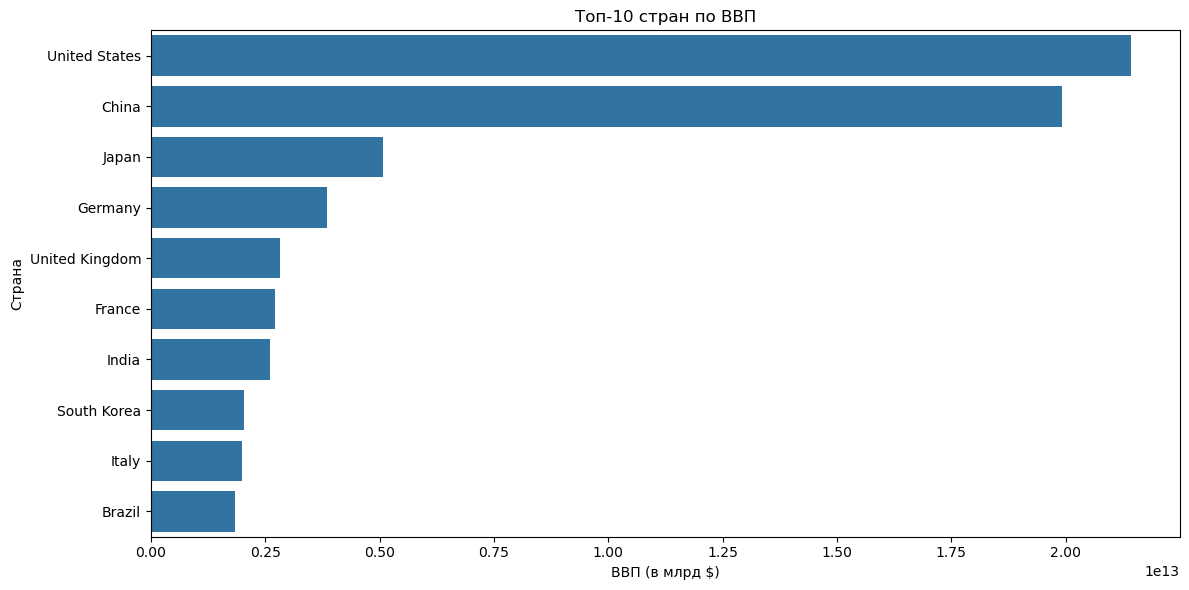

In [46]:
# Анализ 1: Топ-10 стран по ВВП
gdp_top10 = df_gdp_avg.orderBy(desc("Средний ВВП")).limit(10)
gdp_pd = gdp_top10.select("Страна", "Средний ВВП").toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(x="Средний ВВП", y="Страна", data=gdp_pd.sort_values("Средний ВВП", ascending=False))
plt.title("Топ-10 стран по ВВП")
plt.xlabel("ВВП (в млрд $)")
plt.tight_layout()
plt.show()

## Объединение в общий DataFrame

In [77]:
# Объединим датафреймы по странам
df_final = data_spark.join(df_gdp_avg, on="Страна", how="left")
df_final.show(5)

+-------------------+------------+----------------------+------------------+----------+--------------------+-----------+--------------------------+----------+-----------------------+------------------+--------------------+---------------------------------+----------------------+----------------+------------------------+------------------+---------------------+-------------------------+-----------------------+------------------+------------------+----------------+-----------+---------+-------------------+------------------+-------------+------------------+------------------+------------------+------------------------------+---------------------------+--------------------+-------------------+----------------+
|             Страна|Аббревиатура|Размер вооруженных сил|       Рождаемость|Код страны|             Столица|Выбросы CO2|Индекс потребительских цен|Код валюты|Коэффициент рождаемости|Детская смертность|    Крупнейший город|Ожидаемая продолжительность жизни|Материнская смертность|Офиц

## Выявление корреляций

In [54]:
df_final_pd = df_final.toPandas()

In [79]:
df_final_pd.rename(columns={'Обучение в начальной школе (%)':'Обучение_в_начальной_школе'}, inplace=True)

In [80]:
df_final_pd.rename(columns={'Обучение в высшей школе (%)':'Обучение_в_высшей_школе'}, inplace=True)

In [65]:
!pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 24.5 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 17.0 MB/s eta 0:00:00


In [72]:
import pandas as pd
import scipy as sc
import seaborn as sns
from scipy.stats import norm
import numpy as np
import statsmodels.formula.api as sm


import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

In [86]:
model_df = sm.ols(formula="ВВП ~ Население + Обучение_в_начальной_школе + Обучение_в_высшей_школе", data=df_final_pd).fit()
model_df.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ВВП   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.430
Method:                 Least Squares   F-statistic:                     49.69
Date:                Sun, 01 Jun 2025   Prob (F-statistic):           8.75e-24
Time:                        00:50:51   Log-Likelihood:                -5758.3
No. Observations:                 195   AIC:                         1.152e+04
Df Residuals:                     191   BIC:                         1.154e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                   1.316e+09   5.18e+11      0.003      0.998   -1.02e+12    1.02e+12
Население                   9357.6722    811.899     11.526      0.000    7756.232     1.1e+04
Обучение_в_начальной_школе -4.145e+09   5.18e+09     -0.801      0.424   -1.44e+10    6.07e+09
Обучение_в_высшей_школе     1.443e+10      4e+09      3.602      0.000    6.53e+09    2.23e+10
==============================================================================
Omnibus:                      272.699   Durbin-Watson:                   2.251
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            49253.983
Skew:                           5.650   Prob(JB):                         0.00
Kurtosis:                      80.035   Cond. No.                     6.63e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.63e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Согласно множественной линейной регрессии R2 =43,8% это значит,что модель объясняет  43,8%  изменчивости ВВП. Это относительно небольшое значение, указывающее на среднее соответствие модели данным (если учитывать, что данных немного, то и показатели точности соответствующие).
Значение  p  почти для двух характеристик крайне мало, за исключением обучения в начальной школе, где  p = 0.424 > 0,05, значит ВВП не зависит от уровня образования в начальной школе, в остальном всё указывает на хорошую линейную связь и подтверждает значимость модели.

In [87]:
model_df = sm.ols(formula="ВВП ~ Население", data=df_final_pd).fit()
model_df.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ВВП   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     128.7
Date:                Sun, 01 Jun 2025   Prob (F-statistic):           3.45e-23
Time:                        00:52:23   Log-Likelihood:                -5764.7
No. Observations:                 195   AIC:                         1.153e+04
Df Residuals:                     193   BIC:                         1.154e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.024e+11   1.25e+11      0.822      0.412   -1.43e+11    3.48e+11
Население   9445.7179    832.528     11.346      0.000    7803.697    1.11e+04
==============================================================================
Omnibus:                      277.689   Durbin-Watson:                   2.244
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            51780.504
Skew:                           5.841   Prob(JB):                         0.00
Kurtosis:                      81.972   Cond. No.                     1.55e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.55e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Изучив влияние населения и уровня образования по отдельности с помощью линейной регрессии, было выявлено, что R2 =4% это значит,что модель объясняет  4%  изменчивости ВВП при влиянии обучения в высшей школе. Это очень маленькое значение, указывающее на нехорошее соответствие модели данным.

In [88]:
model_df = sm.ols(formula="ВВП ~ Обучение_в_начальной_школе", data=df_final_pd).fit()
model_df.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ВВП   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.2019
Date:                Sun, 01 Jun 2025   Prob (F-statistic):              0.654
Time:                        00:52:44   Log-Likelihood:                -5814.4
No. Observations:                 195   AIC:                         1.163e+04
Df Residuals:                     193   BIC:                         1.164e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                   1.731e+11   6.84e+11      0.253      0.800   -1.18e+12    1.52e+12
Обучение_в_начальной_школе  3.029e+09   6.74e+09      0.449      0.654   -1.03e+10    1.63e+10
==============================================================================
Omnibus:                      332.203   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            50397.589
Skew:                           8.560   Prob(JB):                         0.00
Kurtosis:                      79.875   Cond. No.                         447.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [89]:
model_df = sm.ols(formula="ВВП ~ Обучение_в_высшей_школе", data=df_final_pd).fit()
model_df.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ВВП   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     9.660
Date:                Sun, 01 Jun 2025   Prob (F-statistic):            0.00217
Time:                        00:53:03   Log-Likelihood:                -5809.8
No. Observations:                 195   AIC:                         1.162e+04
Df Residuals:                     193   BIC:                         1.163e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept               -9.214e+10   2.36e+11     -0.390      0.697   -5.59e+11    3.74e+11
Обучение_в_высшей_школе  1.585e+10    5.1e+09      3.108      0.002    5.79e+09    2.59e+10
==============================================================================
Omnibus:                      329.418   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            48748.189
Skew:                           8.428   Prob(JB):                         0.00
Kurtosis:                      78.602   Cond. No.                         72.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

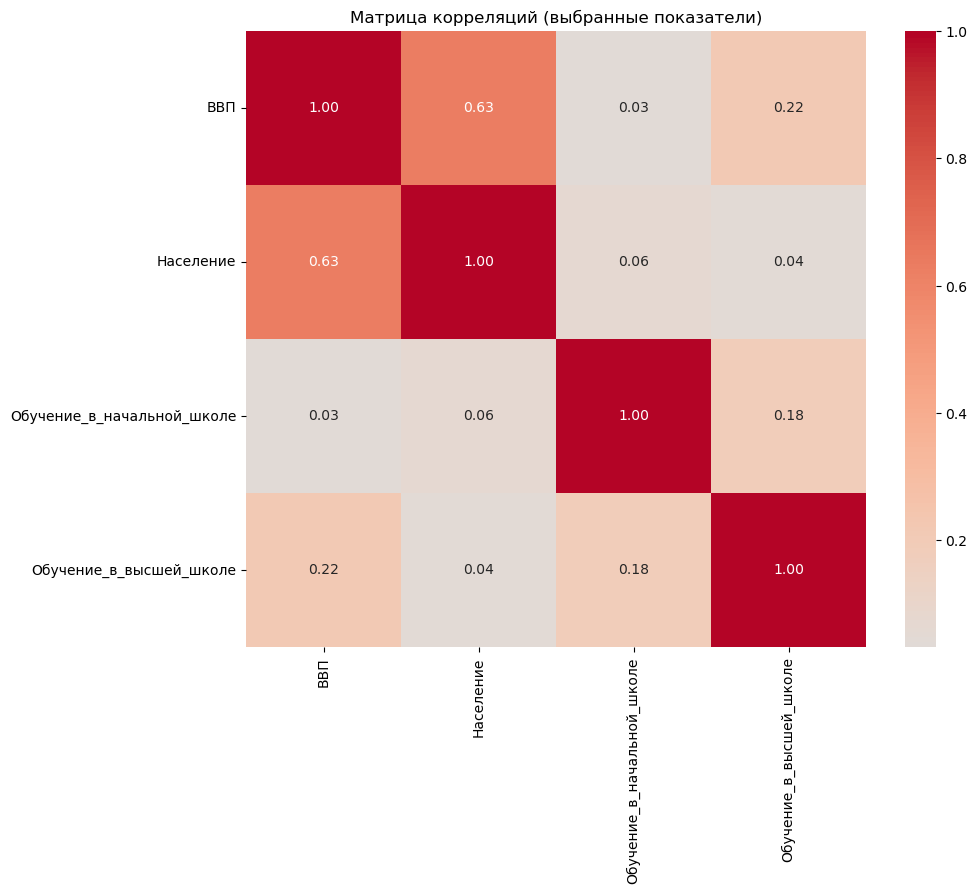

In [90]:
selected_columns = ['ВВП', 'Население', 'Обучение_в_начальной_школе', 'Обучение_в_высшей_школе']

# Фильтруем DataFrame по выбранным столбцам
correlation_data = df_final_pd[selected_columns]

# Вычисляем матрицу корреляций
corr_matrix = correlation_data.corr()

# Визуализируем
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Матрица корреляций (выбранные показатели)')
plt.show()

Матрица корреляций доказала гипотезу влияния по большей степени именно населения на уровень ВВП.

In [91]:
# Путь в HDFS для сохранения
file_path_hdfs = "hdfs://localhost:9000/user3/hadoop/input/economic_data/finaly_data.csv"

# Сохранение DataFrame в формате CSV в HDFS
data_spark.write.csv(file_path_hdfs, header=True, mode='overwrite')